In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel, BertTokenizer, BertForSequenceClassification
import warnings

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
BATCH_SIZE = 16
TEST_SIZE = .2
RANDOM_STATE = 42
EPOCH = 10

## Загрузка и преобразование данных

In [4]:
# Загружаем данные
file_path = r"C:\Users\Skynet\dsprojects\train.csv"
data = pd.read_csv(file_path)

In [5]:
# Просматриваем структуру данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10  8708 non-null   int64  
 15  trend_id_res11  8708 non-null   int64  
 16  trend_id_res12  8708 non-null   int64  
 17  trend_id_res13  8708 non-null   i

Посчитаем сколько нулевых строк

In [6]:
data.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALO...",Доставка просто 👍,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
label_columns = [col for col in data.columns if col.startswith("trend_id_res")]

In [8]:
# Фильтруем строки, где все метки равны 0
rows_with_all_zeros = data[label_columns].sum(axis=1) == 0
count_all_zero_rows = rows_with_all_zeros.sum()

In [9]:
print(f"Количество строк с нулями: {count_all_zero_rows}")

Количество строк с нулями: 4085


Нулевые строки тоже нужны для обучения

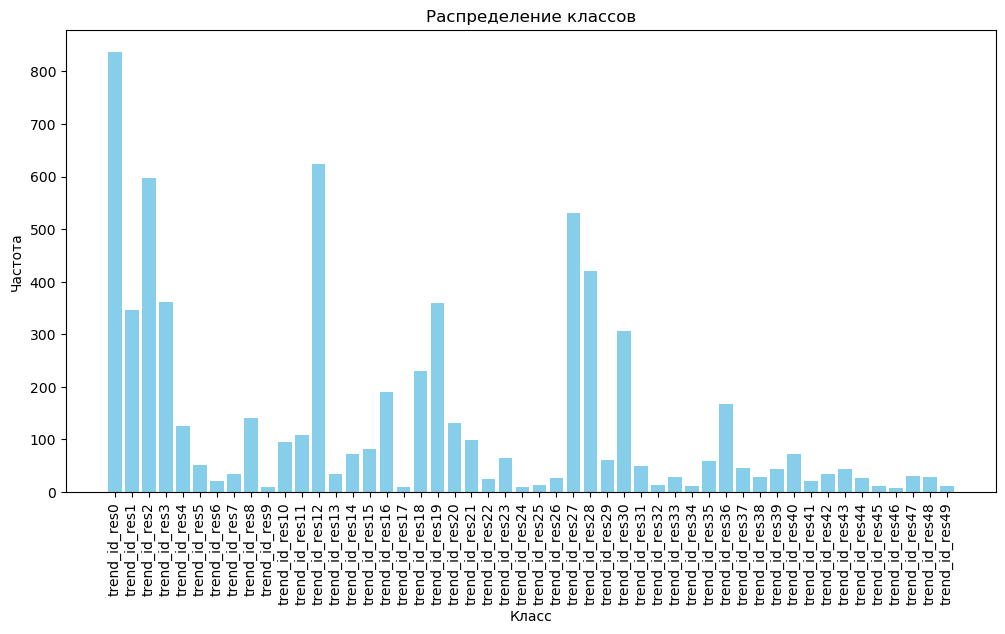

In [10]:
# Пример: Данные с метками (замените на свои данные)
all_labels = data[[f'trend_id_res{i}' for i in range(50)]]

# Подсчет количества положительных меток для каждого класса
class_counts = all_labels.sum(axis=0)

# Таблица частот
class_counts_table = pd.DataFrame({'Class': class_counts.index, 'Frequency': class_counts.values})

# Построение графика распределения
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.xticks(rotation=90)
plt.show()

Наблюдается сильный дисбаланс классов. Путем экспериментов с oversampling, значительно улучшить метрику не удалось, при рандомном oversampling метрика accuracy совсем упала.

Преобразуем данные в вид "Отзыв - Тэги - Оценка"

In [11]:
def cleaner(text):

    if not isinstance(text, str):
        return ""

    text = text.lower()

    text = re.sub(r'http\S+|www\.\S+', '', text)

    text = re.sub(r'<.*?>', '', text)

    # Удаление чисел и спецсимволов (оставляем только буквы и пробелы)
    text = re.sub(r'[^а-яa-zё0-9\s]', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [12]:
def transform_text(row):
    string = f'''Отзыв {row['text']}, тэги {' '.join(row['tags'])}, оценка {row['assessment']}'''
    return string

In [13]:
data['tags'] = data['tags'].fillna('').str.strip('{}').str.split(',')

In [14]:
data['text'] = data.apply(transform_text, axis=1)

In [15]:
data['text'] = data['text'].apply(cleaner)

In [16]:
data.head(3)

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5652,6.0,"[ASSORTMENT, PROMOTIONS, DELIVERY]",отзыв маленький выбор товаров хотелось бы ассо...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18092,4.0,"[ASSORTMENT, PRICE, PRODUCTS_QUALITY, DELIVERY]",отзыв быстро тэги assortment price productsqua...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13845,6.0,"[DELIVERY, PROMOTIONS, PRICE, ASSORTMENT, SUPP...",отзыв доставка постоянно задерживается тэги de...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Инициализация модели и токенизатора

In [17]:
class FeedbackDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

In [18]:
# Загрузка данных
texts = data['text'].tolist()
labels = data[[f'trend_id_res{i}' for i in range(50)]].values

Возьмем модель и токенизатор RuBERT

In [19]:
# Инициализация токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=50, problem_type="multi_label_classification")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Подключим GPU

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


In [21]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [22]:
# Создание датасетов
train_dataset = FeedbackDataset(train_texts, train_labels, tokenizer)
val_dataset = FeedbackDataset(val_texts, val_labels, tokenizer)

## Тренировка модели

In [23]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCH,
    weight_decay=0.02,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    #fp16=torch.cuda.is_available()
)

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    accuracy = (predictions == labels).all(axis=1).mean()
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}

In [25]:
# Тренировка модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.057000,0.069407,0.456372,0.000000
2,0.052000,0.051898,0.485649,0.096365
3,0.042600,0.042833,0.586108,0.349585
4,0.032200,0.037506,0.610792,0.434346
5,0.029700,0.035050,0.648106,0.497526
6,0.025300,0.033691,0.665327,0.546773
7,0.020600,0.031604,0.692882,0.581783
8,0.023400,0.031385,0.694030,0.586892
9,0.017300,0.030812,0.704363,0.605909
10,0.018900,0.030796,0.703789,0.603402


TrainOutput(global_step=4360, training_loss=0.03723763008046588, metrics={'train_runtime': 1153.6437, 'train_samples_per_second': 60.383, 'train_steps_per_second': 3.779, 'total_flos': 2292026889876480.0, 'train_loss': 0.03723763008046588, 'epoch': 10.0})

In [27]:
results = trainer.evaluate()

In [28]:
print("Best model metrics:")
print(results)

Best model metrics:
{'eval_loss': 0.030812200158834457, 'eval_accuracy': 0.7043628013777268, 'eval_f1': 0.6059086810265086, 'eval_runtime': 6.1263, 'eval_samples_per_second': 284.348, 'eval_steps_per_second': 17.792, 'epoch': 10.0}


## Вывод

Тренировочный датасет состоит из тегов, оценок и самих отзывов, а также из 50 категорий для меток (целевые). Выяснилось, что около половины этих строк - полностью нулевые. Хотя нулевые строки нужны, однако это большой процент.

Метрику удалось улучшить с помощью представленных гиперпараметров и методов преобразования данных. Другие методы, к примеру оверсэмплинг и увеличение количество батчей, не улучшали метрику.

Лучшей предобученной моделью для этой задачи оказалась RuBERT от DeepPavlov, количество батчей 16, количество эпох 10.
Метрика Accuracy на валидационном датасете показала 0.70, F1 - 0.61.

Рекомендации заказчику:
- увеличить выборку;
- избавиться от дисбаланса классов;
- возможно дополнительная информация помимо оценки и тегов.